### Import the necessary variables

In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
import math
import seaborn as sns
import impyute as impy

### Jupyter configuration

In [129]:
pd.set_option('display.max_rows', 500)
%matplotlib inline

### Load the dataset for all the countries

In [130]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [131]:
all_countries_dataset = pd.read_csv('all_countries_dataset.csv')

### List all available variables

In [132]:
all_countries_dataset.columns.tolist()

['Unnamed: 0',
 'iso_code',
 'continent',
 'location',
 'date',
 'total_cases',
 'new_cases',
 'new_cases_smoothed',
 'total_deaths',
 'new_deaths',
 'new_deaths_smoothed',
 'total_cases_per_million',
 'new_cases_per_million',
 'new_cases_smoothed_per_million',
 'total_deaths_per_million',
 'new_deaths_per_million',
 'new_deaths_smoothed_per_million',
 'reproduction_rate',
 'icu_patients',
 'icu_patients_per_million',
 'hosp_patients',
 'hosp_patients_per_million',
 'weekly_icu_admissions',
 'weekly_icu_admissions_per_million',
 'weekly_hosp_admissions',
 'weekly_hosp_admissions_per_million',
 'new_tests',
 'total_tests',
 'total_tests_per_thousand',
 'new_tests_per_thousand',
 'new_tests_smoothed',
 'new_tests_smoothed_per_thousand',
 'positive_rate',
 'tests_per_case',
 'tests_units',
 'total_vaccinations',
 'people_vaccinated',
 'people_fully_vaccinated',
 'total_boosters',
 'new_vaccinations',
 'new_vaccinations_smoothed',
 'total_vaccinations_per_hundred',
 'people_vaccinated_per_

### Cap 3:

### Fix variables datatypes

In [133]:
# drop cloumn Unnamed: 0

if 'Unnamed: 0' in all_countries_dataset.columns:
    all_countries_dataset = all_countries_dataset.drop(columns=['Unnamed: 0'])

# Fixing date column datatype
all_countries_dataset['date'] = pd.to_datetime(all_countries_dataset['date']);
# all_countries_dataset['location'] = all_countries_dataset['location'].astype('category');
# all_countries_dataset['continent'] = all_countries_dataset['continent'].astype('category');

# all_countries_dataset.set_index('date', inplace=True)

In [134]:
variables = [
    'continent',
    'location',
    'date',
    'new_cases',
    'new_deaths',
    'icu_patients',
    'new_tests',
    'positive_rate',
    'people_vaccinated',
    'new_vaccinations',
    'total_boosters',
    'stringency_index',
    'population',
    'population_density',
    'cardiovasc_death_rate',
    'diabetes_prevalence',
    'human_development_index'
 ]

In [135]:
def cov_percentage():
    # for each continent
    for continent in all_countries_dataset['continent'].unique():
        # for each country
        for country in all_countries_dataset[all_countries_dataset['continent'] == continent]['location'].unique():
            # for each variable
            for variable in variables:
                country_data = all_countries_dataset[(all_countries_dataset['continent'] == continent) & (all_countries_dataset['location'] == country)]
                percentage_missing = country_data[variable].isnull().sum() / len(country_data)
                print(f'{country} {variable} {percentage_missing * 100}%')

### Exclude unnecessary continents

In [136]:
rule = np.logical_or(all_countries_dataset['continent'] == 'Europe', all_countries_dataset['location'] == 'United States')
dataset = all_countries_dataset[rule]

### Select only the relevant variables that can be used

In report will be needed to be explained why we excluded those variables

In [137]:
variables = [
    'continent',
    'location',
    'date',
    'new_cases',
    'new_deaths',
    'icu_patients',
    'new_tests',
    'positive_rate',
    'people_vaccinated',
    'new_vaccinations',
    'total_boosters',
    'stringency_index',
    'population',
    'population_density',
    'cardiovasc_death_rate',
    'diabetes_prevalence',
    'human_development_index'
 ]

Exclude the unnecessary variables

In [138]:
dataset = dataset[variables]

### Detect the microcountrie (countries that have a population of less than 500 000)

In [139]:
countries = dataset['location'].unique()

population_threshold = 500000
micro_countries = []

for country in countries:
    country_population = dataset[dataset['location'] == country]['population'].max()
    if country_population < population_threshold:
        micro_countries.append(country)

print(len(micro_countries))
micro_countries

11


['Andorra',
 'Faeroe Islands',
 'Gibraltar',
 'Guernsey',
 'Iceland',
 'Isle of Man',
 'Jersey',
 'Liechtenstein',
 'Monaco',
 'San Marino',
 'Vatican']

### Exclude the microcountries

In [140]:
# exclude the micro countries
dataset = dataset[~dataset['location'].isin(micro_countries)]

### Feature scaling

In [141]:
# Perform feature scaling

# take only numerical variables
numerical_variables = [
    'new_cases',
    'new_deaths',
    #'reproduction_rate',
    'icu_patients',
    #'hosp_patients',
    'new_tests',
    'positive_rate',
    'people_vaccinated',
    'new_vaccinations',
    'total_boosters',
    'stringency_index',
    'population',
    'population_density',
    'cardiovasc_death_rate',
    'diabetes_prevalence',
    'human_development_index'
]

# take non-numerical variables
non_numerical_variables = [
    'continent',
    'location',
    'date'
]

# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()

# obj_dataset = dataset[non_numerical_variables].copy()
# num_dataset = dataset[numerical_variables].copy()
# num_dataset_scaled = sc.fit_transform(num_dataset)
# dataset = pd.concat([obj_dataset, pd.DataFrame(data=num_dataset_scaled, columns=numerical_variables)], axis=1)

# dataset.dtypes


### Replace negative values

In [142]:
# removed records where new_cases is negative
# for each numerical variable 
# if new_cases is negative, set it to 0
def remove_negative_values(dataset):
    new_dataset = dataset.copy()
    for variable in variables:
        if variable in ['location', 'continent', 'date']:
            continue
        for index, row in new_dataset.iterrows():
            if index == 0:
                continue
            if row[variable] < 0 and index in new_dataset.index:
                new_dataset.at[index, variable] = new_dataset.at[index - 1, variable]
    return new_dataset

In [143]:
cleaned_dataset = remove_negative_values(dataset)

### Replace first non missing values

In [144]:
def replace_backwards(new_dataset, index, variable, value_to_replace_with):
    while index in new_dataset.index:
        new_dataset.at[index, variable] = value_to_replace_with
        index -= 1

# replace first missing values with first non missing value
def replace_first_missing_values(dataset):
    new_dataset = dataset.copy()
    
    for variable in ['population', 'population_density', 'cardiovasc_death_rate', 'diabetes_prevalence', 'human_development_index']:
        for index, row in dataset.iterrows():
            if not pd.isna(row[variable]):
                replace_backwards(new_dataset, index, variable, row[variable])
                break
    
    for variable in ['new_vaccinations', 'people_vaccinated', 'total_boosters', 'icu_patients', 'new_tests', 'new_cases', 'new_deaths', 'positive_rate', 'stringency_index']:
        for index, row in dataset.iterrows():
            if not pd.isna(row[variable]):
                replace_backwards(new_dataset, index, variable, 0)
                break

    return new_dataset

In [145]:
cleaned_dataset = replace_first_missing_values(cleaned_dataset)

### Replace missing values


In [146]:
def next_non_missing_value(dataset, index, variable):
    next_index = index
    while next_index in dataset.index and pd.isna(dataset.loc[next_index, variable]):
        next_index += 1
    if next_index not in dataset.index:
        return (next_index - 1, -1)
    return (index, dataset.loc[next_index, variable])

def last_non_missing_value(dataset, index, variable):
    last_index = index
    while last_index in dataset.index and pd.isna(dataset.loc[last_index, variable]):
        last_index -= 1
    if last_index not in dataset.index:
        return (last_index + 1, -1)
    return (index, dataset.loc[last_index, variable])

def replace_missing_values(dataset):
    df = dataset.copy()
    new_dataset = pd.DataFrame()
    for country in df['location'].unique():
        country_dataset = df[df['location'] == country]
        for variable in variables:
            if variable in ['location', 'continent', 'date']:
                continue
            found_non_missing = False
            for index, row in country_dataset.iterrows():
                if pd.isna(row[variable]):
                    if found_non_missing and (index - 1) in country_dataset.index and (index + 1) in country_dataset.index:
                        next = next_non_missing_value(country_dataset, index, variable)
                        last = last_non_missing_value(country_dataset, index, variable)
                        if next[1] == -1 or last[1] == -1:
                            continue
                        new_val = (next[1] - last[1]) / 2
                        country_dataset.loc[index, variable] = last[1] + new_val
                else:
                    found_non_missing = True
        new_dataset = pd.concat([new_dataset, country_dataset])
    return new_dataset

In [147]:
cleaned_dataset = replace_missing_values(cleaned_dataset)

/home/ion/.local/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


### Remove anomalies

In [148]:
def split_dataframe(a, n): 
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

In [149]:
def get_mean(dataset, variable):
    sum = 0
    max = dataset[variable].max()
    if pd.isna(max):
        return 0
    count = 0
    for index, row in dataset.iterrows():
        if (~pd.isna(row[variable]) and row[variable] < max) == True:
            sum = sum + row[variable]
            count = count + 1
    if sum == 0:
        return 0
    return sum / count

In [150]:
def remove_anomalies(dataset):
    new_dataset = pd.DataFrame()
    for country in dataset['location'].unique():
        new_country_data = pd.DataFrame()
        country_data = dataset[dataset['location'] == country]
        dataset_chunks = split_dataframe(country_data, 25)

        for chunk in dataset_chunks:
            for variable in variables:
                if variable in ['location', 'continent', 'date']:
                    continue
                anomaly_indexes = chunk[chunk[variable] > chunk[variable].quantile(0.99)].index
                for index in anomaly_indexes:
                    if index - 1 in chunk.index:
                        chunk.at[index, variable] = chunk.at[index - 1, variable]
            new_country_data = new_country_data.append(chunk)
        
        new_dataset = new_dataset.append(new_country_data)

    return new_dataset

In [151]:
cleaned_dataset = remove_anomalies(cleaned_dataset)

### Show the coverage percentage for hosp_patiens and icu_patients

In [152]:
def show_coverage(dataset, variables):
    for country in dataset['location'].unique():
        for variable in variables:
            count = 0
            country_data = dataset[dataset['location'] == country]
            for index, row in country_data.iterrows():
                if not pd.isna(row[variable]):
                    count = count + 1
            covered = count / country_data.shape[0] * 100
            print("{}, {} = {} %".format(country, variable, covered))
        print("\n")

In [153]:
show_coverage(cleaned_dataset, ['icu_patients'])

Albania, icu_patients = 0.0 %


Austria, icu_patients = 98.7012987012987 %


Belarus, icu_patients = 0.0 %


Belgium, icu_patients = 92.4646781789639 %


Bosnia and Herzegovina, icu_patients = 0.0 %


Bulgaria, icu_patients = 93.87417218543047 %


Croatia, icu_patients = 0.0 %


Cyprus, icu_patients = 98.50993377483444 %


Czechia, icu_patients = 97.57281553398059 %


Denmark, icu_patients = 89.2018779342723 %


Estonia, icu_patients = 95.141065830721 %


Finland, icu_patients = 90.6687402799378 %


France, icu_patients = 98.30246913580247 %


Germany, icu_patients = 90.54263565891473 %


Greece, icu_patients = 0.0 %


Hungary, icu_patients = 0.0 %


Ireland, icu_patients = 94.28104575163398 %


Italy, icu_patients = 95.00780031201248 %


Kosovo, icu_patients = 0.0 %


Latvia, icu_patients = 0.0 %


Lithuania, icu_patients = 0.0 %


Luxembourg, icu_patients = 98.70340356564019 %


Malta, icu_patients = 98.35255354200989 %


Moldova, icu_patients = 0.0 %


Montenegro, icu_patients = 0.0

Remove countries that don't have data for icu_patients variable

In [154]:
def remove_countries_without_data(dataset, variables):
    new_dataset = pd.DataFrame()

    for country in dataset['location'].unique():
        for variable in variables:
            count = 0
            country_data = dataset[dataset['location'] == country]
            for index, row in country_data.iterrows():
                if not pd.isna(row[variable]):
                    count = count + 1
            covered = count / country_data.shape[0] * 100
            if covered != 0:
                new_dataset = new_dataset.append(country_data)
    return new_dataset

In [155]:
# cleaned_dataset = remove_countries_without_data(cleaned_dataset, ['icu_patients'])

In [156]:
cleaned_dataset['location'].unique()

array(['Albania', 'Austria', 'Belarus', 'Belgium',
       'Bosnia and Herzegovina', 'Bulgaria', 'Croatia', 'Cyprus',
       'Czechia', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany',
       'Greece', 'Hungary', 'Ireland', 'Italy', 'Kosovo', 'Latvia',
       'Lithuania', 'Luxembourg', 'Malta', 'Moldova', 'Montenegro',
       'Netherlands', 'North Macedonia', 'Norway', 'Poland', 'Portugal',
       'Romania', 'Russia', 'Serbia', 'Slovakia', 'Slovenia', 'Spain',
       'Sweden', 'Switzerland', 'Ukraine', 'United Kingdom',
       'United States'], dtype=object)

In [157]:
cleaned_dataset.to_csv('cleaned_dataset.csv')

In [158]:
cleaned_dataset.corr()

,new_cases,new_deaths,icu_patients,new_tests,positive_rate,people_vaccinated,new_vaccinations,total_boosters,stringency_index,population,population_density,cardiovasc_death_rate,diabetes_prevalence,human_development_index
new_cases,1.000000,0.820878,0.900230,0.809739,0.102271,0.516525,0.507372,0.448191,0.121986,0.672457,-0.055503,-0.095151,0.169764,0.112381
new_deaths,0.820878,1.000000,0.872676,0.733697,0.134810,0.421296,0.554315,0.508043,0.188332,0.725427,-0.069822,-0.062757,0.171511,0.085005
icu_patients,0.900230,0.872676,1.000000,0.806052,0.122777,0.600376,0.532213,0.488099,0.184524,0.848064,-0.109645,-0.087014,0.295700,0.084737
new_tests,0.809739,0.733697,0.806052,1.000000,-0.075682,0.695780,0.707242,0.552545,0.127133,0.781874,-0.047959,-0.154226,0.136725,0.172276
positive_rate,0.102271,0.134810,0.122777,-0.075682,1.000000,-0.093858,-0.071584,0.091484,0.183685,-0.022358,-0.078618,0.270968,0.225405,-0.331216
people_vaccinated,0.516525,0.421296,0.600376,0.695780,-0.093858,1.000000,0.607492,0.674075,0.004447,0.818383,-0.048858,-0.181881,0.182333,0.194582
new_vaccinations,0.507372,0.554315,0.532213,0.707242,-0.071584,0.607492,1.000000,0.336948,0.100869,0.751543,-0.058157,-0.165223,0.165893,0.170799
total_boosters,0.448191,0.508043,0.488099,0.552545,0.091484,0.674075,0.336948,1.000000,-0.033984,0.612750,-0.076152,-0.030768,0.272904,0.040483
stringency_index,0.121986,0.188332,0.184524,0.127133,0.183685,0.004447,0.100869,-0.033984,1.000000,0.084315,0.049753,-0.147144,0.064317,0.059899
population,0.672457,0.725427,0.848064,0.781874,-0.022358,0.818383,0.751543,0.612750,0.084315,1.000000,-0.094572,-0.086188,0.216408,0.134807


### Plots

In [159]:
def plot_vars_per_country(dataset, cleaned_dataset):
    for continent in dataset['continent'].unique():
        print(continent)

        continent_data = dataset[dataset['continent'] == continent]
        continent_data_cleaned = cleaned_dataset[cleaned_dataset['continent'] == continent]

        for variable in variables:
            if variable == 'location' or variable == 'continent' or variable == 'date':
                continue
            continent_countries = continent_data['location'].unique()

            # set fig size
            plt.figure(figsize=(50, 20))

            for country in continent_countries:
                country_data = continent_data[continent_data['location'] == country]
                plt.plot(country_data['date'], country_data[variable], label=country)

            plt.legend()
            plt.title("{} - {}".format(continent, variable))
            plt.show()

            # set fig size
            plt.figure(figsize=(50, 20))

            for country in continent_countries:
                country_data_cleaned = continent_data_cleaned[continent_data_cleaned['location'] == country]
                plt.plot(country_data_cleaned['date'], country_data_cleaned[variable], label=country)

            plt.legend()
            plt.title("{} - {}".format(continent, variable))
            plt.show()


In [160]:
# plot_vars_per_country(dataset, cleaned_dataset)

VARMAX

In [161]:
# dataset - diff_dataset
def inverse_differenciate(dataset):
    # for variable in dataset.columns:
    #     if variable == 'location' or variable == 'continent' or variable == 'date':
    #         continue
    #     dataset[variable] = cleaned_dataset[variable].shift(1) + dataset[variable]

    for variable in dataset.columns:
        if variable == 'location' or variable == 'continent' or variable == 'date':
            continue
        dataset[variable] = pd.Series(np.r_[cleaned_dataset[variable], dataset[variable]].cumsum())

    return dataset

In [162]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [163]:
cleaned_dataset.index = pd.to_datetime(cleaned_dataset.date)
cleaned_dataset.index.freq = cleaned_dataset.index.inferred_freq

In [164]:
def replace_nans(dataset):
    # for each country
    new_dataset = pd.DataFrame()

    for country in dataset['location'].unique():
        country_dataset = dataset[dataset['location'] == country]

        for variable in numerical_variables:
            for index, row in country_dataset.iterrows():
                if pd.isna(row[variable]) or row[variable] == float('inf') or row[variable] == float('-inf'):
                    previous_timestamp = index - pd.Timedelta(days=1)
                    if previous_timestamp in country_dataset.index and pd.isna(country_dataset.loc[previous_timestamp, variable]) == False:
                        country_dataset.at[index, variable] = country_dataset.at[previous_timestamp, variable]
                    else:
                        country_dataset.at[index, variable] = 0
                        
        new_dataset = pd.concat([new_dataset, country_dataset], axis=0)

    return new_dataset

In [165]:
cleaned_dataset = replace_nans(cleaned_dataset)

In [166]:
# augmented dickey-fuller test
from statsmodels.tsa.stattools import adfuller

def dickey_fuller_test(dataset):
    for country in dataset.location.unique():
        country_dataset = dataset[dataset['location'] == country]
        print("{}".format(country))
        for variable in numerical_variables:
            print("{}".format(variable))

            X = np.asarray(country_dataset[variable])
            result = adfuller(X)

            print('ADF Statistic: %f' % result[0])
            print('p-value: %f' % result[1])

            print('\n')

        print('\n')
        print("=============================")


In [167]:
# dickey_fuller_test(cleaned_dataset)

In [168]:
# take only numerical variables
numerical_variables = [
    'new_cases',
    'new_deaths',
    'icu_patients',
    'new_tests',
    'positive_rate',
    'people_vaccinated',
    'new_vaccinations',
    'total_boosters',
    'stringency_index',
    'population',
    'population_density',
    'cardiovasc_death_rate',
    'diabetes_prevalence',
    'human_development_index'
]

# take non-numerical variables
non_numerical_variables = [
    'continent',
    'location',
    'date'
]

varmax_dataset = cleaned_dataset.copy()

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

obj_dataset = varmax_dataset[non_numerical_variables].copy()
num_dataset = varmax_dataset[numerical_variables].copy()
# num_dataset = sc.fit_transform(num_dataset)

num_dataset = pd.DataFrame(num_dataset, columns=numerical_variables)


num_dataset = np.log(num_dataset)

# Take First Difference to Remove Trend
num_dataset = num_dataset.diff()

num_dataset = num_dataset.diff()

# Remove Increasing Volatility
# num_dataset = num_dataset.groupby(num_dataset.index.year).std()

varmax_dataset = pd.concat([obj_dataset, pd.DataFrame(data=num_dataset, columns=numerical_variables)], axis=1)

varmax_dataset.dtypes

continent                          object
location                           object
date                       datetime64[ns]
new_cases                         float64
new_deaths                        float64
icu_patients                      float64
new_tests                         float64
positive_rate                     float64
people_vaccinated                 float64
new_vaccinations                  float64
total_boosters                    float64
stringency_index                  float64
population                        float64
population_density                float64
cardiovasc_death_rate             float64
diabetes_prevalence               float64
human_development_index           float64
dtype: object

In [169]:
varmax_dataset.index = pd.to_datetime(varmax_dataset.date)
varmax_dataset.index.freq = varmax_dataset.index.inferred_freq

In [170]:
varmax_dataset = replace_nans(varmax_dataset)

### Add lag variables for new deaths

In [171]:
varmax_dataset['new_deaths_0'] = varmax_dataset['new_deaths'].shift(1)
varmax_dataset['new_deaths_1'] = varmax_dataset['new_deaths'].shift(2)
varmax_dataset['new_deaths_2'] = varmax_dataset['new_deaths'].shift(3)
varmax_dataset = varmax_dataset.dropna()

### Split into train and test

In [172]:
# split into train and test
training_date_limit = date(2021, 10, 1)

varmax_dataset.index = pd.to_datetime(varmax_dataset.date)
varmax_dataset.index.freq = varmax_dataset.index.inferred_freq

varmax_train_dataset = varmax_dataset[varmax_dataset['date'].dt.date < training_date_limit]
varmax_test_dataset = varmax_dataset[varmax_dataset['date'].dt.date >= training_date_limit]

In [173]:
import statsmodels.api as sm

exogeneous_variables = [
    'population',
    'population_density',
    'diabetes_prevalence',
    'human_development_index',
    'new_tests',
    'stringency_index',
    'icu_patients',
    'cardiovasc_death_rate',
    'people_vaccinated',
    'new_vaccinations',
    'total_boosters',
    'positive_rate',
    'new_cases',
    #'new_deaths'
]

endogeneous_variables = [
    'new_deaths_0',
    'new_deaths_1',
    'new_deaths_2'
]

In [174]:
print(varmax_train_dataset.location.unique())

['Albania' 'Austria' 'Belarus' 'Belgium' 'Bosnia and Herzegovina'
 'Bulgaria' 'Croatia' 'Cyprus' 'Czechia' 'Denmark' 'Estonia' 'Finland'
 'France' 'Germany' 'Greece' 'Hungary' 'Ireland' 'Italy' 'Kosovo' 'Latvia'
 'Lithuania' 'Luxembourg' 'Malta' 'Moldova' 'Montenegro' 'Netherlands'
 'North Macedonia' 'Norway' 'Poland' 'Portugal' 'Romania' 'Russia'
 'Serbia' 'Slovakia' 'Slovenia' 'Spain' 'Sweden' 'Switzerland' 'Ukraine'
 'United Kingdom' 'United States']


### ACF and PACF

https://www.youtube.com/watch?v=CAT0Y66nPhs&ab_channel=DataScienceShow

In [175]:
print(len(numerical_variables))

14


In [176]:
import matplotlib.pyplot as plt

def plot_acf_per_country(dataset):
    for country in dataset['location'].unique():
        country_dataset = dataset[dataset['location'] == country]

        print('\n')
        fig = plt.figure(figsize=(30, 15))
        for index, variable in enumerate(numerical_variables):
            # add plot_acf to subplot for each variable
            ax = fig.add_subplot(4, 4, index + 1)
            plot_acf(country_dataset[variable], ax=ax, lags=300)
            ax.set_title(variable)

        fig.suptitle(country)
        fig.show()

def plot_pacf_per_country(dataset):
    for country in dataset['location'].unique():
        country_dataset = dataset[dataset['location'] == country]

        print('\n')
        fig = plt.figure(figsize=(30, 15))
        for index, variable in enumerate(numerical_variables):
            # add plot_acf to subplot for each variable
            ax = fig.add_subplot(4, 4, index + 1)
            plot_pacf(country_dataset[variable], ax=ax)
            ax.set_title(variable)

        fig.suptitle(country)
        fig.show()

In [177]:
# plot_pacf_per_country(varmax_train_dataset)

In [178]:
us_dataset = varmax_train_dataset[varmax_train_dataset['location'] == 'United States']
us_dataset.corr()

,new_cases,new_deaths,icu_patients,new_tests,positive_rate,people_vaccinated,new_vaccinations,total_boosters,stringency_index,population,population_density,cardiovasc_death_rate,diabetes_prevalence,human_development_index,new_deaths_0,new_deaths_1,new_deaths_2
new_cases,1.000000,0.603574,0.217463,0.471962,0.367957,0.023437,0.463381,0.079360,0.126099,0.000000,0.000000,0.000000,0.000000,0.000000,-0.265637,-0.150071,0.144452
new_deaths,0.603574,1.000000,0.178082,0.547812,0.216825,0.053948,0.401560,0.093117,-0.069874,0.000000,0.000000,0.000000,0.000000,0.000000,-0.394041,-0.180492,0.098527
icu_patients,0.217463,0.178082,1.000000,0.221519,0.115992,-0.002770,0.147577,0.096447,0.012054,0.000000,0.000000,0.000000,0.000000,0.000000,-0.110661,-0.106477,0.085412
new_tests,0.471962,0.547812,0.221519,1.000000,0.144922,0.069272,0.624110,0.104547,0.125384,0.000000,0.000000,0.000000,0.000000,0.000000,-0.014764,-0.327160,0.061700
positive_rate,0.367957,0.216825,0.115992,0.144922,1.000000,-0.019142,0.189166,0.005131,0.063195,0.000000,0.000000,0.000000,0.000000,0.000000,-0.063211,-0.053154,0.025003
people_vaccinated,0.023437,0.053948,-0.002770,0.069272,-0.019142,1.000000,0.138107,0.003298,0.000233,0.000000,0.000000,0.000000,0.000000,0.000000,0.037350,-0.008873,-0.033545
new_vaccinations,0.463381,0.401560,0.147577,0.624110,0.189166,0.138107,1.000000,0.093617,0.054671,0.000000,0.000000,0.000000,0.000000,0.000000,-0.127205,-0.151714,0.056549
total_boosters,0.079360,0.093117,0.096447,0.104547,0.005131,0.003298,0.093617,1.000000,0.001044,0.000000,0.000000,0.000000,0.000000,0.000000,0.064031,-0.069760,-0.011213
stringency_index,0.126099,-0.069874,0.012054,0.125384,0.063195,0.000233,0.054671,0.001044,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.130915,-0.082738,-0.059568
population,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-1.000000,1.000000,1.000000,-1.000000,0.010364,-0.037274,0.017676


### Dickey-fuller test

In [179]:
# dickey_fuller_test(varmax_train_dataset)

In [180]:
mod = sm.tsa.VARMAX(np.asarray(varmax_train_dataset[endogeneous_variables]), np.asarray(varmax_train_dataset[exogeneous_variables]), order=(3, 0))

In [181]:
res = mod.fit(disp=True)
res.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           75     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.47150D-01    |proj g|=  8.88900D+00


 This problem is unconstrained.



At iterate    1    f= -7.61283D-01    |proj g|=  4.05872D+01

At iterate    2    f= -7.80769D-01    |proj g|=  2.09660D+01

At iterate    3    f= -8.16004D-01    |proj g|=  4.49227D+01

At iterate    4    f= -8.85315D-01    |proj g|=  7.79538D+01

At iterate    5    f= -1.03308D+00    |proj g|=  1.09564D+02

At iterate    6    f= -1.23346D+00    |proj g|=  1.06559D+02

At iterate    7    f= -1.26781D+00    |proj g|=  7.68973D+01

At iterate    8    f= -1.35545D+00    |proj g|=  3.12071D+01

At iterate    9    f= -1.37109D+00    |proj g|=  5.96134D+00

At iterate   10    f= -1.37283D+00    |proj g|=  5.56600D+00

At iterate   11    f= -1.37517D+00    |proj g|=  8.86717D+00

At iterate   12    f= -1.38492D+00    |proj g|=  1.69793D+01

At iterate   13    f= -1.40528D+00    |proj g|=  2.64338D+01

At iterate   14    f= -1.41661D+00    |proj g|=  4.43987D+01

At iterate   15    f= -1.44935D+00    |proj g|=  3.26327D+01

At iterate   16    f= -1.49272D+00    |proj g|=  1.47206D+01

At iter

/home/ion/.local/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -1.67199D+00    |proj g|=  2.38583D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   75     50     59      1     0     0   2.386D+01  -1.672D+00
  F =  -1.6719862167783550     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


Dep. Variable:,"['y1', 'y2', 'y3']",No. Observations:,24159
Model:,VARX(3),Log Likelihood,40393.515
,+ intercept,AIC,-80637.030
Date:,"Mon, 17 Jan 2022",BIC,-80030.099
Time:,18:33:25,HQIC,-80440.262
Sample:,0,,
,- 24159,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"2.03, 400.52, 33.83",Jarque-Bera (JB):,"29231.21, 2485774832.86, 2364877399.31"
Prob(Q):,"0.15, 0.00, 0.00",Prob(JB):,"0.00, 0.00, 0.00"
Heteroskedasticity (H):,"1.01, 0.38, 1.04",Skew:,"0.45, -14.59, -11.76"


In [182]:
# set index to be date
varmax_train_dataset.index = pd.to_datetime(varmax_train_dataset.date)
varmax_train_dataset.index.freq = varmax_train_dataset.index.inferred_freq

varmax_train_dataset

,continent,location,date,new_cases,new_deaths,icu_patients,new_tests,positive_rate,people_vaccinated,new_vaccinations,total_boosters,stringency_index,population,population_density,cardiovasc_death_rate,diabetes_prevalence,human_development_index,new_deaths_0,new_deaths_1,new_deaths_2
date,,,,,,,,,,,,,,,,,,,,
2020-02-28,Europe,Albania,2020-02-28,0.000000,0.000000,0.000000,-1.163151,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2020-02-29,Europe,Albania,2020-02-29,0.000000,0.000000,0.000000,3.465736,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2020-03-01,Europe,Albania,2020-03-01,0.000000,0.000000,0.000000,-3.060271,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2020-03-02,Europe,Albania,2020-03-02,0.000000,0.000000,0.000000,0.575364,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2020-03-03,Europe,Albania,2020-03-03,0.000000,0.000000,0.000000,1.321756,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-26,North America,United States,2021-09-26,0.976191,0.827167,0.012124,-0.090634,0.013606,-0.000403,-0.123346,-0.029441,0.0,0.0,0.0,0.0,0.0,0.0,-0.926822,-0.413453,-0.053599
2021-09-27,North America,United States,2021-09-27,2.079026,1.905268,-0.004443,0.772578,0.000000,0.000860,1.419843,0.085216,0.0,0.0,0.0,0.0,0.0,0.0,0.827167,-0.926822,-0.413453
2021-09-28,North America,United States,2021-09-28,-2.250915,-1.619491,-0.004572,0.092038,-0.013793,-0.000036,-0.824893,-0.007882,0.0,0.0,0.0,0.0,0.0,0.0,1.905268,0.827167,-0.926822


In [183]:
real_us_data_endog = np.asarray(varmax_test_dataset[varmax_test_dataset['location'] == 'United States'][endogeneous_variables])
real_us_data_exog = np.asarray(varmax_test_dataset[varmax_test_dataset['location'] == 'United States'][exogeneous_variables])

In [184]:
forecasted = res.forecast(exog=real_us_data_exog, steps=real_us_data_exog.shape[0])
print(forecasted)


[[ 0.28445734  0.26923466 -1.61885392]
 [-0.1458959   0.29011008  0.25642228]
 [-0.05591445 -0.14590887  0.29596822]
 [ 0.16089067 -0.05531589 -0.12773251]
 [-0.03005507  0.16371833 -0.07673352]
 [ 0.02965572 -0.02751083  0.16540892]
 [ 0.05525272  0.01346085 -0.02198021]
 [ 0.033988    0.06282008  0.01759534]
 [ 0.01379967  0.03783414  0.04189435]
 [ 0.06610083  0.00931725  0.04637727]
 [ 0.07600699  0.07078339  0.0282967 ]
 [ 0.02433676  0.07888812  0.04862044]
 [ 0.0685499   0.01901553  0.08102048]
 [ 0.04348517  0.06741187  0.02230707]
 [ 0.06626461  0.04130272  0.07044265]
 [ 0.02665219  0.06895735  0.02530315]
 [ 0.07125233  0.02240735  0.07448052]
 [ 0.08911325  0.07793861  0.04325137]
 [ 0.03822238  0.08939635  0.05305613]
 [ 0.07511004  0.03238889  0.09512912]
 [ 0.04826982  0.07549973  0.03488891]
 [ 0.06867411  0.04235845  0.08398634]
 [ 0.03463545  0.07217294  0.02567897]
 [ 0.07710687  0.03113607  0.07316988]
 [ 0.10435529  0.08130082  0.03602698]
 [ 0.00252784  0.10348604

In [185]:
real_us_data_endog_df = pd.DataFrame(varmax_test_dataset[varmax_test_dataset['location'] == 'United States']['new_deaths'], columns=['new_deaths'])
forecasted_df = pd.DataFrame(forecasted, columns=endogeneous_variables)

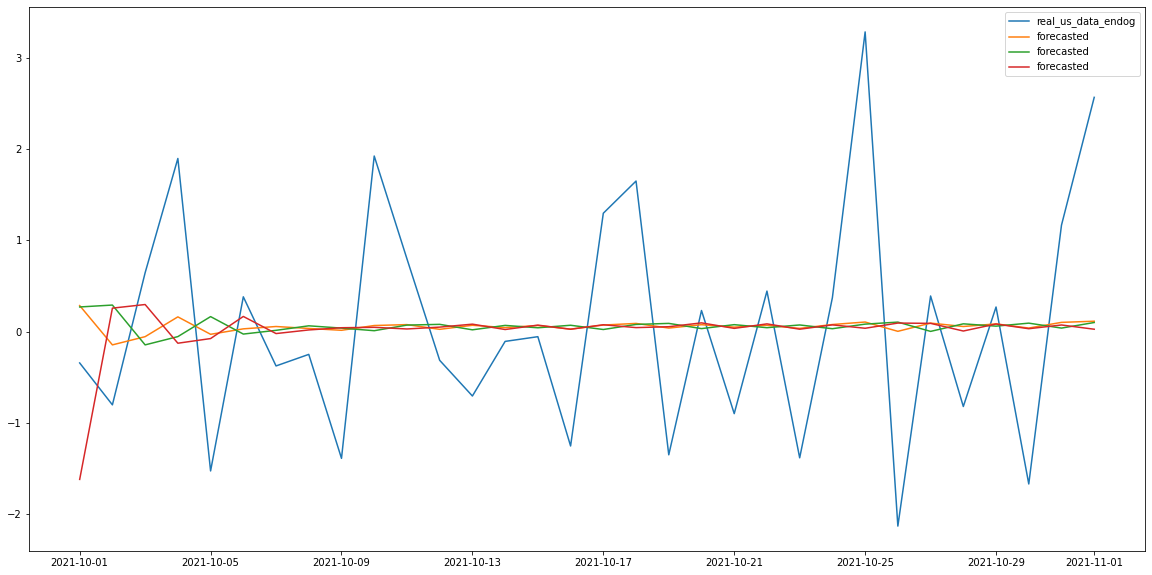

In [186]:
# set index for forecasted be equal to real_us_data_endog_df index
forecasted_df.index = real_us_data_endog_df.index

# plot real_us_data_endog_df  vs forecasted_df
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(real_us_data_endog_df, label='real_us_data_endog')
ax.plot(forecasted_df, label='forecasted')
ax.legend()


In [187]:
for i in range(len(forecasted)):
   print(real_us_data_endog[i], forecasted[i])

[-0.11132429  0.27060123 -1.61949055] [ 0.28445734  0.26923466 -1.61885392]
[-0.34375083 -0.11132429  0.27060123] [-0.1458959   0.29011008  0.25642228]
[-0.80241519 -0.34375083 -0.11132429] [-0.05591445 -0.14590887  0.29596822]
[ 0.64400011 -0.80241519 -0.34375083] [ 0.16089067 -0.05531589 -0.12773251]
[ 1.89505026  0.64400011 -0.80241519] [-0.03005507  0.16371833 -0.07673352]
[-1.52619817  1.89505026  0.64400011] [ 0.02965572 -0.02751083  0.16540892]
[ 0.38047773 -1.52619817  1.89505026] [ 0.05525272  0.01346085 -0.02198021]
[-0.3764649   0.38047773 -1.52619817] [0.033988   0.06282008 0.01759534]
[-0.24992369 -0.3764649   0.38047773] [0.01379967 0.03783414 0.04189435]
[-1.38833018 -0.24992369 -0.3764649 ] [0.06610083 0.00931725 0.04637727]
[ 1.92191472 -1.38833018 -0.24992369] [0.07600699 0.07078339 0.0282967 ]
[ 0.79623037  1.92191472 -1.38833018] [0.02433676 0.07888812 0.04862044]
[-0.3148648   0.79623037  1.92191472] [0.0685499  0.01901553 0.08102048]
[-0.70572051 -0.3148648   0.79

In [188]:
# calculate the goodness of fit
from sklearn.metrics import mean_squared_error


def calculate_rmse(real_data, forecasted_data):
    return np.sqrt(mean_squared_error(real_data[0], forecasted_data[0]))

calculate_rmse(real_us_data_endog, forecasted)

0.2285062871853012

In [189]:
# get real_us_data_endog values into a list
real_us_data_endog


array([[-0.11132429,  0.27060123, -1.61949055],
       [-0.34375083, -0.11132429,  0.27060123],
       [-0.80241519, -0.34375083, -0.11132429],
       [ 0.64400011, -0.80241519, -0.34375083],
       [ 1.89505026,  0.64400011, -0.80241519],
       [-1.52619817,  1.89505026,  0.64400011],
       [ 0.38047773, -1.52619817,  1.89505026],
       [-0.3764649 ,  0.38047773, -1.52619817],
       [-0.24992369, -0.3764649 ,  0.38047773],
       [-1.38833018, -0.24992369, -0.3764649 ],
       [ 1.92191472, -1.38833018, -0.24992369],
       [ 0.79623037,  1.92191472, -1.38833018],
       [-0.3148648 ,  0.79623037,  1.92191472],
       [-0.70572051, -0.3148648 ,  0.79623037],
       [-0.107709  , -0.70572051, -0.3148648 ],
       [-0.05616571, -0.107709  , -0.70572051],
       [-1.25283807, -0.05616571, -0.107709  ],
       [ 1.29542711, -1.25283807, -0.05616571],
       [ 1.64791389,  1.29542711, -1.25283807],
       [-1.34946575,  1.64791389,  1.29542711],
       [ 0.23053513, -1.34946575,  1.647

In [190]:
# calculate r2
from sklearn.metrics import r2_score


def calculate_r2(real_data, forecasted_data):
    return r2_score(real_data[4], forecasted_data[4])

# get real_us_data_endog first column into and np array
# real_us_data_endog = np.asarray(real_us_data_endog_df['new_deaths'])
forecasted = np.asarray(forecasted_df['new_deaths_0'])

calculate_r2(real_us_data_endog, forecasted)

TypeError: Singleton array -0.030055072623236673 cannot be considered a valid collection.

In [ ]:
print(len(varmax_train_dataset[varmax_train_dataset['location'] == 'United States'][endogeneous_variables].values))

618


In [ ]:
prediction = res.get_prediction(start=pd.to_datetime(varmax_train_dataset['date'].max()), dynamic=False)
prediction_mean = prediction.predicted_mean
prediction_mean = pd.DataFrame(prediction_mean, columns=endogeneous_variables)

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

### AutoARIMA

In [ ]:
# # get the data only for United States
# us_dataset = varmax_train_dataset[varmax_train_dataset['location'] == 'United States']

# # import autoarima 
# from pmdarima.arima import auto_arima
# from pmdarima.arima import ADFTest

# # adf_test = ADFTest(alpha=0.05)
# # adf_test = adf_test.should_diff(us_dataset['new_deaths'])

# constant_variables = [
#     'population',
#     'population_density',
#     'cardiovasc_death_rate',
#     'diabetes_prevalence',
#     'human_development_index'
# ]

# pq = {}

# all_country_p_sum = 0
# all_country_q_sum = 0
# for country in varmax_train_dataset['location'].unique():
#     country_train_dataset = varmax_train_dataset[varmax_train_dataset['location'] == country]
#     print("Using auto_arima for {}".format(country))

#     p_sum = 0
#     q_sum = 0

#     country_p_q = {}

#     for variable in numerical_variables:
#         if variable in constant_variables:
#             continue
#         print("Using auto_arima for {}".format(variable))
#         arima_model = auto_arima(country_train_dataset[variable], start_p=0, start_q=0,
#                                     test='adf',
#                                     max_p=5,
#                                     max_q=5,
#                                     m=4,
#                                     trace=True,
#                                     error_action='warn')
#         arima_model.summary()

#         country_p_q[variable] = {
#             'p': arima_model.order[0],
#             'q': arima_model.order[1]
#         }

#         # get p and q from the summary
#         p_sum += arima_model.order[0]
#         q_sum += arima_model.order[1]
    
#         print('\n')

#     pq[country] = country_p_q
    

#     print('\n')

#     p_mean = p_sum / len(numerical_variables)
#     q_mean = q_sum / len(numerical_variables)
#     all_country_p_sum = all_country_p_sum + p_mean
#     all_country_q_sum = all_country_q_sum + q_mean

#     print("p_mean: {}".format(p_mean))
#     print("q_mean: {}".format(q_mean))
#     print('\n')
#     print("=============================")

# print("all_country_p_mean: {}".format(all_country_p_sum / len(varmax_train_dataset['location'].unique())))
# print("all_country_q_mean: {}".format(all_country_q_sum/ len(varmax_train_dataset['location'].unique())))

# print(pq)

In [ ]:
# arima_model.scoring(us_dataset_test['new_deaths'])

In [ ]:
# plot_vars_per_country(dataset, varmax_dataset)